# Table of Contents
1. [Libraries](#importing-libraries)
2. [Data](#Importing-Data)
3. [HOG_feature_extraction](#hog-feature-extraction)
4. [GLCM_feature_extraction](#glcm-feature-extraction)
5. [Feature_Fusion](#feature-fusion)
6. [Split_Data](#split-data-into-train-test-and-validation-part)
7. [LighGBM_GridSearch](#lightgbm-gridsearch)
8. [LightGBM](#light-gbm-model)
9. [XGBoost_GridSearch](#XGBoost)
10. [Ensemble_models](#ensemble-modeling)
11. [Statistics](#statistics)
12. [Datapipleline](#data-pipeline)

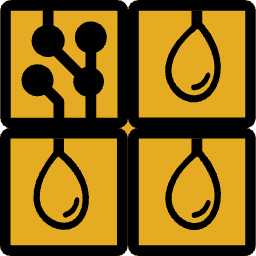

# importing Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import DMatrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from skimage.transform import resize
from skimage import data, color, exposure
from xgboost.callback import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing import image as IMG
from statsmodels.stats.contingency_tables import mcnemar
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

# Importing Data

## Copy Right

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")

# print("Path to dataset files:", path)

## Pixel Intensity

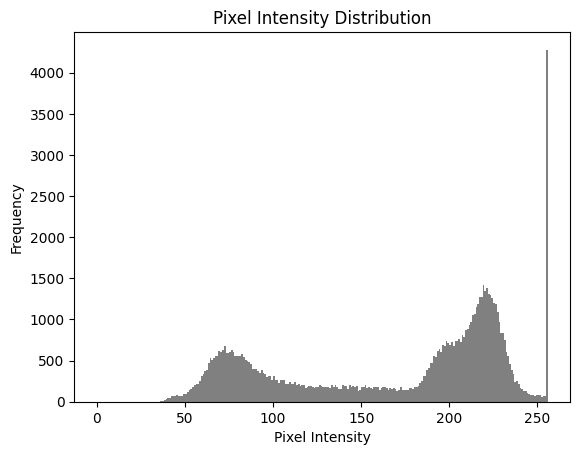

In [2]:
image = cv2.imread("Images/COVID/Covid (2).png", cv2.IMREAD_GRAYSCALE)

plt.hist(image.ravel(), bins=256, range=(0, 256), color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.savefig("Statistics\\pixel intensity.png",dpi = 2500 ,format= 'png')
plt.show()
# ths code is being usd to see where we have more pixel itensity. 
# based on this we can define the Threshod

### Sample Threshold

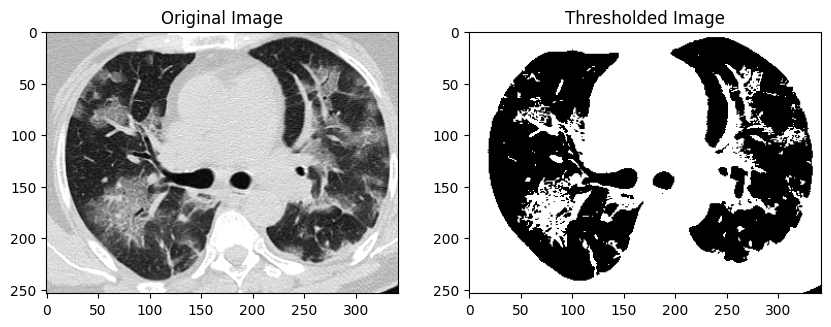

In [3]:
image = cv2.imread("Images/COVID/Covid (2).png", cv2.IMREAD_GRAYSCALE)

_, image_threshold = cv2.threshold(image, 70, 220, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1,2,2)
plt.title("Thresholded Image")
plt.imshow(image_threshold, cmap='gray')
plt.savefig("Statistics\\ threshold picure.png", dpi = 2500, format = "png")
plt.show()

## Importing Data

In [2]:
IMG_SIZE = (64, 64)
DATASET_PATH = "Images"

In [3]:
# I used this Function to load and flatten images, Also using Threshold to increse the model performance
def load_data():
    images, labels = [], []
    categories = ["COVID", "non-COVID"]
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        label = 1 if category == "COVID" else 0  # COVID: 1, NonCOVID: 0
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            #_, img = cv2.threshold(img, 70, 220, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img.flatten())  # Flatten the image to a 1D array
                labels.append(label)
    
    return np.array(images), np.array(labels)

# Load the data
X, Y = load_data()
print("Shape of data:", X.shape)

Shape of data: (2480, 4096)


## HOG feature extraction

In [5]:
def load_data_with_hog():
    images, labels = [], []
    categories = ["COVID", "non-COVID"]
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        label = 1 if category == "COVID" else 0  # COVID: 1, NonCOVID: 0
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            _, img = cv2.threshold(img, 70, 220, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
            
                hog_features = hog(
                    img,
                    orientations=32,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=False
                )
                images.append(hog_features)
                labels.append(label)
    
    return np.array(images), np.array(labels)
X_hog, y = load_data_with_hog()
print("HOG Features Shape:", X_hog.shape)


HOG Features Shape: (2480, 6272)


## GLCM feature extraction:

In [41]:
def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    features = [
    graycoprops(glcm, 'contrast')[0, 0],
    graycoprops(glcm, 'correlation')[0, 0],
    graycoprops(glcm, 'energy')[0, 0],
    graycoprops(glcm, 'homogeneity')[0, 0],
    graycoprops(glcm, 'dissimilarity')[0, 0]  
    ]

    return features

def load_data_with_glcm():
    images, labels = [], []
    categories = ["COVID", "non-COVID"]
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        label = 1 if category == "COVID" else 0  # COVID: 1, NonCOVID: 0
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Otsu's Thresholding
            _, img = cv2.threshold(img, 70, 220, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                
                # Extract GLCM features
                glcm_features = extract_glcm_features(img)
                images.append(glcm_features)  # Append the GLCM features
                labels.append(label)
    
    return np.array(images), np.array(labels)

# Example usage:
X_glcm, y = load_data_with_glcm()
print("GLCM Features Shape:", X_glcm.shape)

GLCM Features Shape: (2480, 5)


## Feature Fusion

### Hog feature Fusion

In [44]:
def load_images():
    images, labels = [], []
    categories = ["COVID", "non-COVID"]
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        label = 1 if category == "COVID" else 0
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img.flatten())
                labels.append(label)
    return np.array(images), np.array(labels)

def hogs(images):
    hog_features = []
    for img in images:
        featur = hog(
            img, orientations=8,
            pixels_per_cell = (16, 16),
            cells_per_block = (1, 1),
        )
        hog_features.append(featur)
        return hog_features

### GLCM Feature Fuaion

In [45]:
def load_images():
    images, labels = [], []
    categories = ["COVID", "non-COVID"]
    
    for category in categories:
        category_path = os.path.join(DATASET_PATH, category)
        label = 1 if category == "COVID" else 0
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

def GLCMs(images):
    glcm_features = []
    for img in images:
        glcm = graycomatrix(img, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

        features = [
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0],
            graycoprops(glcm, 'dissimilarity')[0, 0]  
            ]
        glcm_features.append(features)
    glcm_features = np.array(glcm_features)  # Shape: (n_samples, n_features)

    return glcm_features

### Fused Features

In [46]:
images, labels = load_images()

In [47]:
hog_features = hogs(images)
glcm_features = GLCMs(images)
hog_scaler = StandardScaler()
glcm_scaler = StandardScaler()
hog_normalized = hog_scaler.fit_transform(hog_features)
glcm_normalized = glcm_scaler.fit_transform(glcm_features)

In [48]:
hog_normalized = np.tile(hog_normalized, (glcm_normalized.shape[0], 1))

In [49]:
fused_features = np.hstack((hog_normalized, glcm_normalized)) 
# Since the hog_features didn'nt have same number of rows as the glsm_features,
#I applied this to make the hog-features have same rows as the glcm_features.

## Class Weights

In [8]:
def number_of_files(file_path):
    num_files = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])
    return num_files

In [9]:
class_labels = np.array([0, 1])

num_samples = np.array([number_of_files('C:\\Users\\Ali khatami\\Desktop\\Uni\\Challenge2\\Dt\\Covid CT scan\\Images\\non-COVID'), number_of_files('C:\\Users\\Ali khatami\\Desktop\\Uni\\Challenge2\\Dt\\Covid CT scan\\Images\\COVID')])  
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=np.concatenate([
    np.zeros(num_samples[0]),  
    np.ones(num_samples[1])    
]))

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.0089503661513426, 1: 0.991207034372502}


# Split data into train, test and validation part

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_hog, y, test_size= 0.1, random_state= 42)

In [7]:
x_train.shape

(2232, 6272)

# LightGBM GridSearch

In [1]:
lgbm = LGBMClassifier(device="gpu")
param_dist = {
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1],
    "num_leaves": [15, 31, 50, 100],
    "max_depth": [3, 5, 7, 10],
    "min_data_in_leaf": [20, 50, 100, 200],
    "feature_fraction": [0.5, 0.7, 0.9, 1.0],
    "bagging_fraction": [0.5, 0.7, 0.9, 1.0],
    "lambda_l1": [0.0, 0.1, 0.5, 1.0],
    "lambda_l2": [0.0, 0.1, 0.5, 1.0],
    "n_estimators": [500, 1000, 2000, 3000],
    "min_gain_to_split": [0.0, 0.01, 0.05, 0.1]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,         
    scoring="recall", 
    cv=5,              
    verbose=1,
    n_jobs=-1,         
    random_state=42
)

# Run Randomized Search
random_search.fit(x_train, y_train)

# Print the best parameters and score
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-validation Accuracy: {random_search.best_score_:.4f}")

# Train the final model with best params
best_lgbm = random_search.best_estimator_
best_lgbm.fit(x_train, y_train)

# Evaluate on test set
test_accuracy = best_lgbm.score(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'LGBMClassifier' is not defined

Best Hyperparameters: {'num_leaves': 50, 
'n_estimators': 2000, 'min_gain_to_split': 0.0, 
'min_data_in_leaf': 200, 'max_depth': 5, 
'learning_rate': 0.1, 'lambda_l2': 0.1, 
'lambda_l1': 1.0, 'feature_fraction': 0.7, 
'bagging_fraction': 1.0}
Best Cross-validation Accuracy: 0.9042

    "boosting_type": "gbdt",       
    "learning_rate": 0.05,         
    "num_leaves": 31,              
    "max_depth": -1,               
    "min_data_in_leaf": 50,        
    "feature_fraction": 0.8,       
    "bagging_fraction": 0.8,       
    "bagging_freq": 5,             
    "lambda_l1": 0.1,              
    "lambda_l2": 0.1,              
    "min_gain_to_split": 0.02,     
    "max_bin": 255,                
    "verbosity": -1,               
    "device": "gpu",               
    "n_estimators": 10, 

# Light GBM Model

Cross-validation scores: [0.812749 0.844    0.788    0.82     0.824   ]
Mean accuracy: 0.8177498007968127
Standard deviation: 0.01812876146322741

Accuracy of the LightGBM model: 0.8467741935483871
Classification report for LightGBM model:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       136
           1       0.80      0.88      0.84       112

    accuracy                           0.85       248
   macro avg       0.85      0.85      0.85       248
weighted avg       0.85      0.85      0.85       248




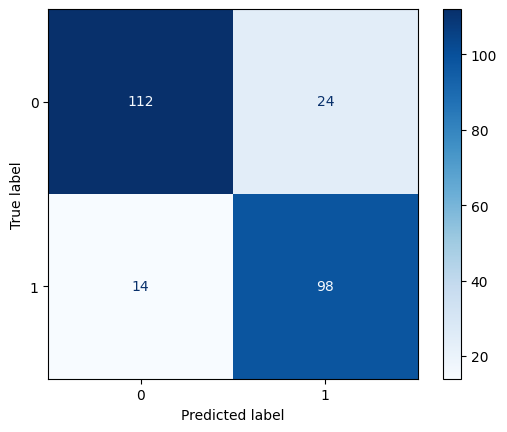

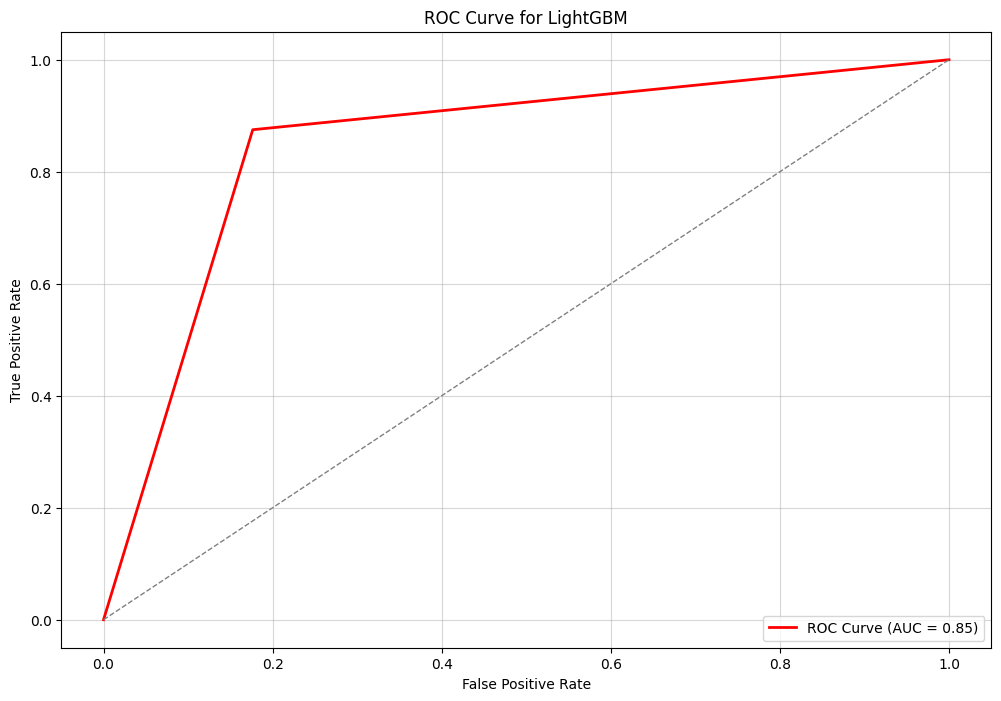

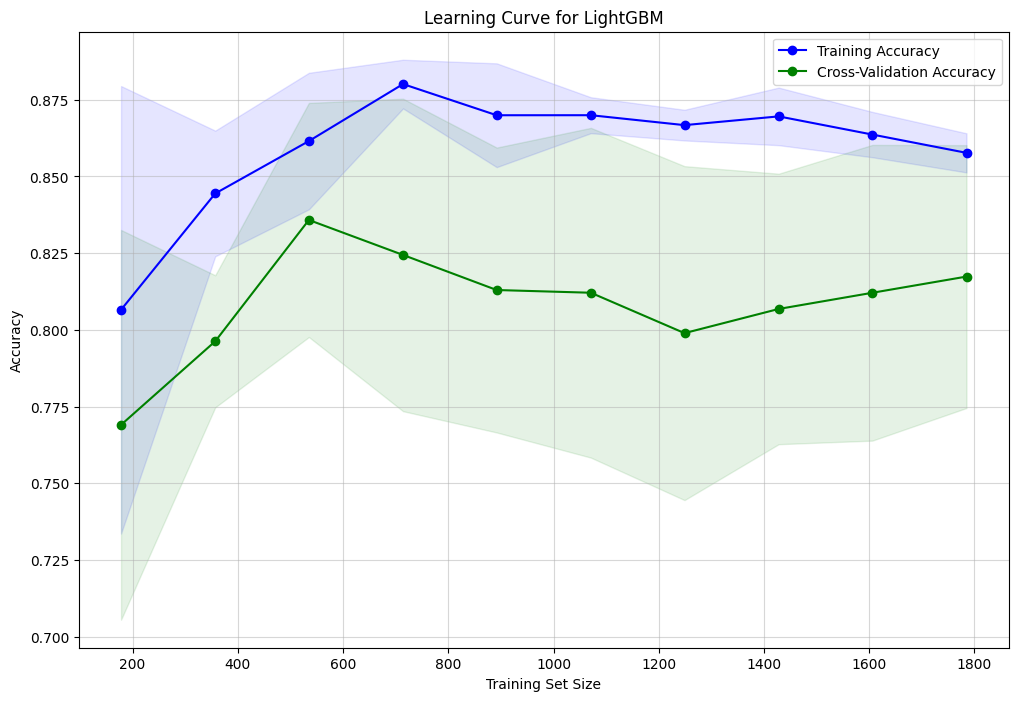

In [10]:
params = {
    "boosting_type": "gbdt",       
    "learning_rate": 0.1,         
    "num_leaves": 10,             
    "max_depth": 15,               
    "min_data_in_leaf": 50,        
    "feature_fraction": 0.8,       
    "bagging_fraction": 0.8,       
    "bagging_freq": 5,             
    "lambda_l1": 0.1,              
    "lambda_l2": 0.1,              
    "min_gain_to_split": 0.02,     
    "max_bin": 255,                
    "verbosity": -1,               
    "device": "gpu",               
    "n_estimators": 10,          
}

lightgbm_model = LGBMClassifier(**params, class_weight=class_weight_dict)

lightgbm_scores = cross_val_score(lightgbm_model, X, Y,
                                  cv= StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42),
                                  scoring='recall')

print(f"Cross-validation scores: {lightgbm_scores}")
print(f"Mean accuracy: {lightgbm_scores.mean()}")
print(f"Standard deviation: {lightgbm_scores.std()}\n")

lightgbm_model.fit(x_train, y_train)
lightgbm_prediction = lightgbm_model.predict(x_test)

print(f"Accuracy of the LightGBM model: {accuracy_score(y_test, lightgbm_prediction)}")
print(f"Classification report for LightGBM model:\n{classification_report(y_test, lightgbm_prediction)}\n")
cm_light = confusion_matrix(y_test, lightgbm_prediction, labels=lightgbm_model.classes_)
display_matrix_light = ConfusionMatrixDisplay(confusion_matrix=cm_light)
display_matrix_light.plot(cmap="Blues")
plt.savefig('Statistics\\Confusion matrix LightGBM .png', dpi = 2500, format= 'png')
plt.show()

fpr_light, tpr_light, thresholds_light = roc_curve(y_test, lightgbm_prediction)
auc_score_light = auc(fpr_light, tpr_light)

plt.figure(figsize=(12, 8))
plt.plot(fpr_light, tpr_light, color='red', lw=2, label=f'ROC Curve (AUC = {auc_score_light:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.savefig('Statistics\\ROC Curve LightGBM .png', dpi = 2500, format= 'png')
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    lightgbm_model, x_train, y_train, cv=5, scoring='recall',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-Validation Accuracy", color="green", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)
plt.title("Learning Curve for LightGBM")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(alpha=0.5)
plt.savefig('Statistics\\Learning Curve LightGBM .png', dpi = 2500, format= 'png')
plt.show()

# RandomForest Model

In [ ]:
RandomForest_model = RandomForestClassifier(n_estimators=110, min_samples_split=17,
                                            min_samples_leaf=4, max_depth=10,
                                            bootstrap=False, class_weight=class_weight_dict,
                                            random_state=42)

cross validation score: [0.77192982 0.80263158 0.85964912 0.85087719 0.81497797]
mean Recall: 0.8200131385733055
standars deviation: 0.032134335806956

random forest accuracy : 0.8508064516129032
classification report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       136
           1       0.84      0.83      0.83       112

    accuracy                           0.85       248
   macro avg       0.85      0.85      0.85       248
weighted avg       0.85      0.85      0.85       248





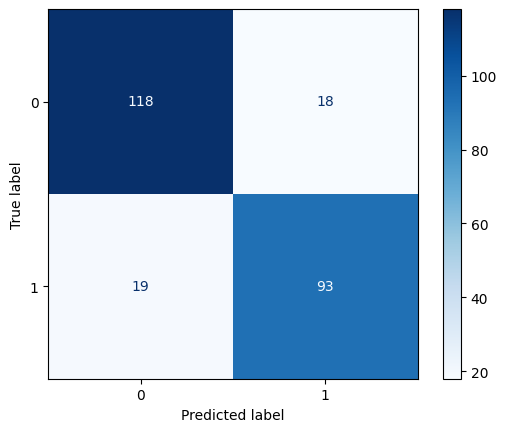

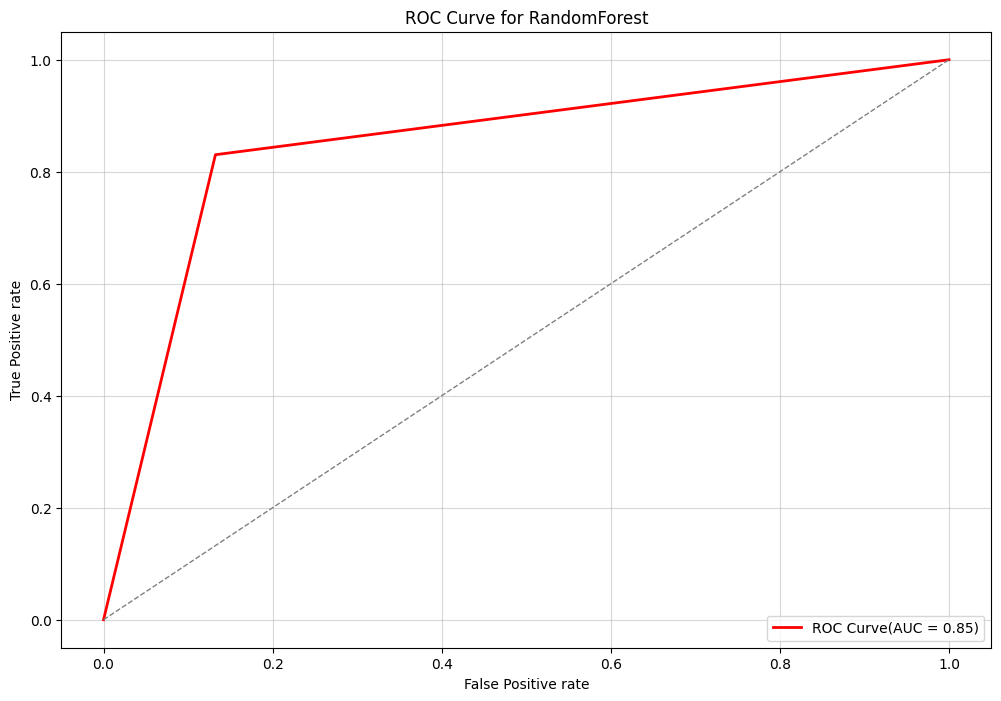

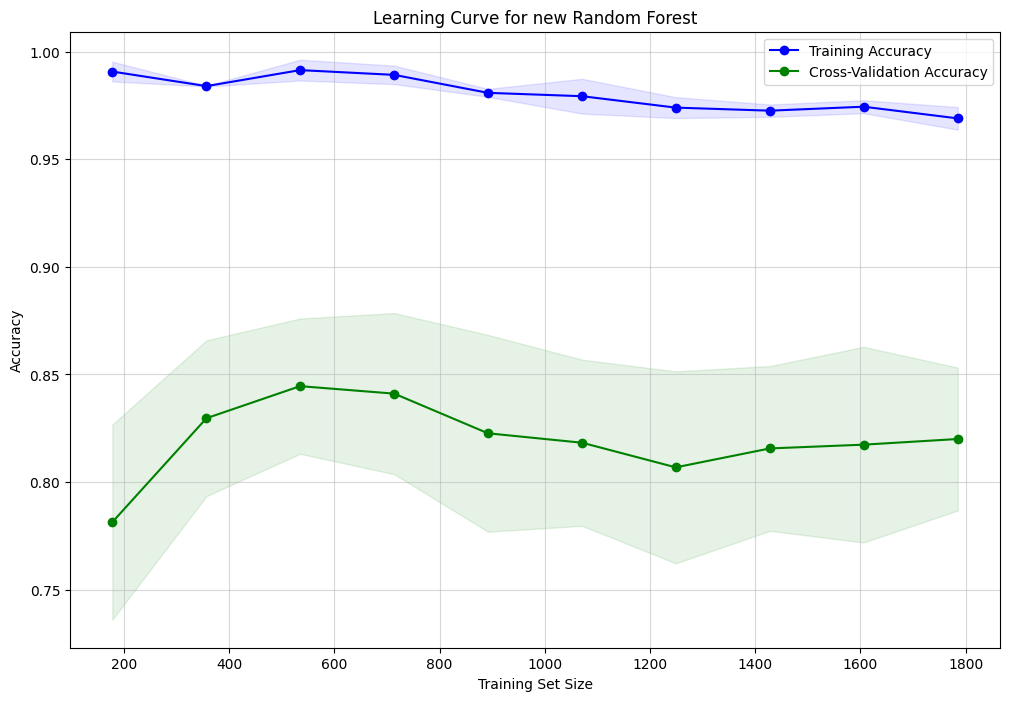

In [41]:
scores_random_forest = cross_val_score(RandomForest_model, x_train,y_train, cv=5, scoring= 'recall')
print(f"cross validation score: {scores_random_forest}")
print(f"mean Recall: {scores_random_forest.mean()}")
print(f"standars deviation: {scores_random_forest.std()}")
print()
RandomForest_model.fit(x_train, y_train)
RandomForest_prediction = RandomForest_model.predict(x_test)
print(f"random forest accuracy : {accuracy_score(y_test, RandomForest_prediction)}")
print(f"classification report:\n {classification_report(y_test, RandomForest_prediction)}")
print()
cm = confusion_matrix(y_test, RandomForest_prediction, labels= RandomForest_model.classes_)
display_matrix = ConfusionMatrixDisplay(confusion_matrix= cm)
display_matrix.plot(cmap="Blues")
#plt.savefig('Statistics\\Confusion matrix randomforest No thresh.png', dpi = 2500, format= 'png')
print()
fpr, tpr, thresholds = roc_curve(y_test, RandomForest_prediction)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = f'ROC Curve(AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--', lw =1)
plt.xlabel('False Positive rate')
plt.ylabel("True Positive rate")
plt.title("ROC Curve for RandomForest")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
#plt.savefig('Statistics\\ROC curve randomforest No thresh.png', dpi = 2500,format= 'png')
plt.show()
print()
train_sizes, train_scores, test_scores =learning_curve(RandomForest_model,
                                                       x_train, y_train, cv= 5, scoring='recall', 
                                                       train_sizes= np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis= 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis= 1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)

plt.plot(train_sizes, test_mean, label="Cross-Validation Accuracy", color="green", marker="o")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)

plt.title("Learning Curve for new Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(alpha=0.5)
#plt.savefig('Statistics\\learning curve randomforest No thresh.png', dpi = 2500, format= 'png')
plt.show()

# XGBoost

## train test split for XGBoost

In [10]:
x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, Y, test_size= 0.2, random_state= 42)
# X_train_sub, X_val, y_train_sub, y_val = train_test_split(
#     x_train_xgb, y_train_xgb, test_size=0.2, random_state=42
# ) # it was for early stopping to prevent overfit

## XGB Grid search

In [ ]:
XGB_param_grid = {
    'n_estimators': [i for i in range(1, 200, 10)],  
    'max_depth': [i for i in range(1, 10, 1)],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1, 0.2] 
}

XGB_model_Grid = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_XGB = RandomizedSearchCV(
    estimator=XGB_model_Grid,
    param_distributions=XGB_param_grid,
    scoring='recall',  
    cv=5,  
    verbose=2,  
    n_jobs=-1  
)

grid_search_XGB.fit(x_train_xgb, y_train_xgb)


print(f"Best Parameters: {grid_search_XGB.best_params_}")
print(f"Best Recall Score: {grid_search_XGB.best_score_:.4f}")

best_xgb_model = grid_search_XGB.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameters: {'subsample': 1.0, 'n_estimators': 71,
'max_depth': 5, 'learning_rate': 0.2, 
'gamma': 0.1, 'colsample_bytree': 0.8}
Best Recall Score: 0.8754


## XGB Model

Cross validation scores:[0.86699507 0.86206897 0.86138614 0.87623762 0.83168317]
Mean recall:  0.8596741940203871
standard deiation : 0.014967335712526059

Acuuracy of the Gradiant Boosting Machines model : 0.8891129032258065
Classification report for Gradiant Boosting Machines model 
:               precision    recall  f1-score   support

           0       0.87      0.93      0.90       257
           1       0.92      0.85      0.88       239

    accuracy                           0.89       496
   macro avg       0.89      0.89      0.89       496
weighted avg       0.89      0.89      0.89       496





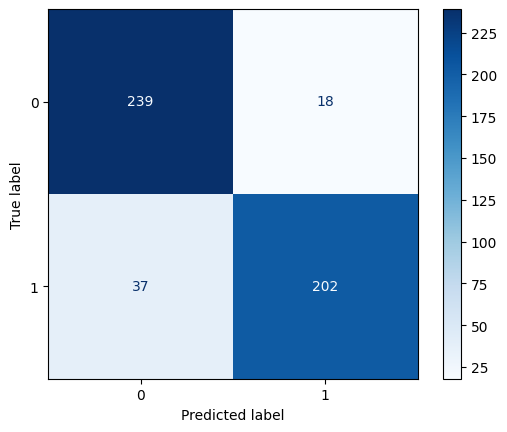

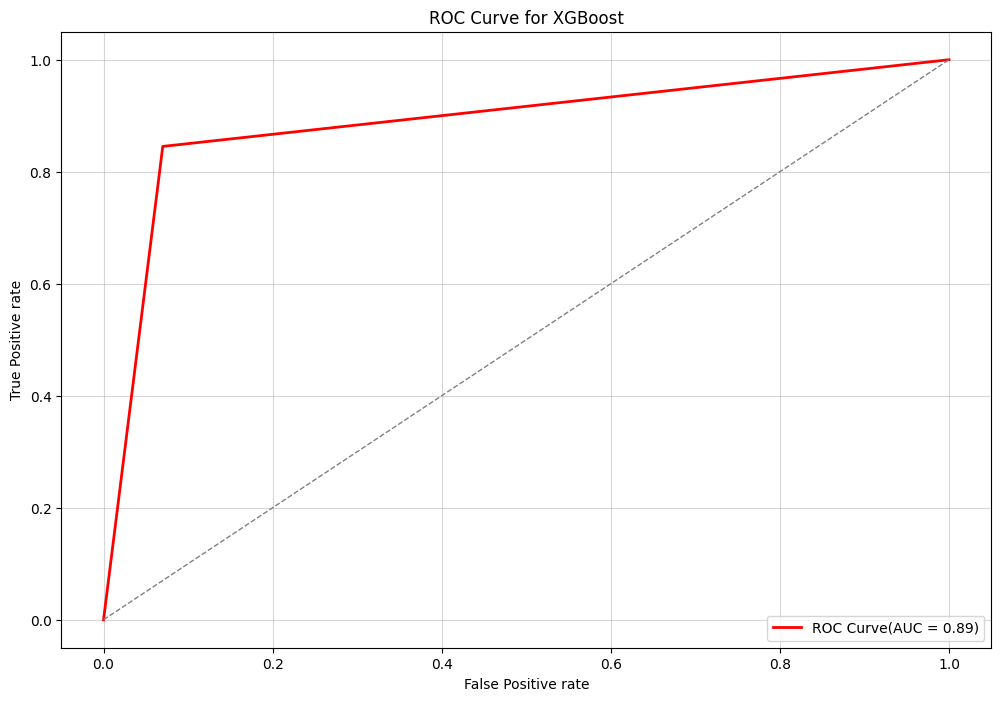

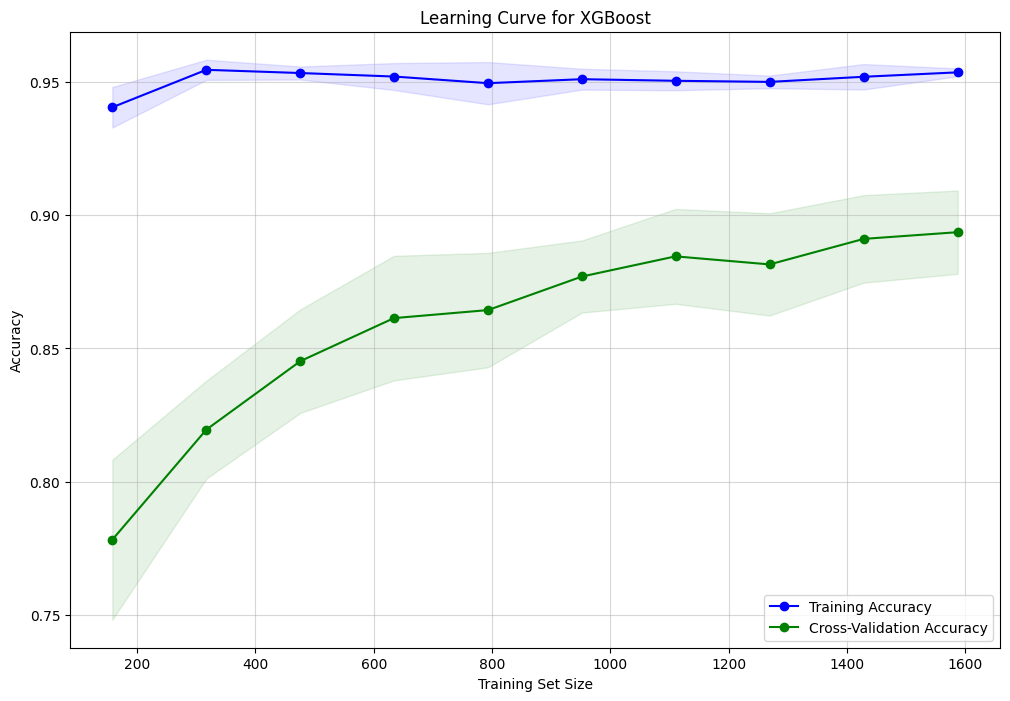

In [11]:
scale_weight = sum(y_train_xgb == 0)/sum(y_train_xgb == 1) # as the XGBoost does not support the class weight I should use another way to do it
XGB_model = xgb.XGBClassifier(scale_pos_weight=scale_weight,
    learning_rate = 0.1,      #0.1               
    n_estimators=70,
    max_depth=5,
    min_child_weight=4,
    gamma=10,
    subsample=0.5,
    colsample_bytree=0.4,
    )
XGB_scores = cross_val_score(XGB_model, x_train_xgb, y_train_xgb,
                             cv=StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42),
                             scoring = 'recall')

print(f"Cross validation scores:{XGB_scores}")
print(f"Mean recall:  {XGB_scores.mean()}")
print(f"standard deiation : {XGB_scores.std()}")
print()
XGB_model.fit(x_train_xgb, y_train_xgb)

XGB_prediction = XGB_model.predict(x_test_xgb)
print(f"Acuuracy of the Gradiant Boosting Machines model : {accuracy_score(y_test_xgb, XGB_prediction)}")
print(f"Classification report for Gradiant Boosting Machines model \n: {classification_report(y_test_xgb, XGB_prediction)}")
print()
cm_XGB = confusion_matrix(y_test_xgb, XGB_prediction, labels= XGB_model.classes_)
display_matrix_XGB = ConfusionMatrixDisplay(confusion_matrix= cm_XGB)
display_matrix_XGB.plot(cmap="Blues")
plt.savefig('Statistics\\Confusion matrix XGBoost Fused.png', format= 'png')
print()
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test_xgb, XGB_prediction)
auc_score_XGB = auc(fpr_XGB, tpr_XGB)

plt.figure(figsize=(12, 8))
plt.plot(fpr_XGB, tpr_XGB, color = 'red', lw = 2, label = f'ROC Curve(AUC = {auc_score_XGB:.2f})')
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--', lw =1)
plt.xlabel('False Positive rate')
plt.ylabel("True Positive rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.savefig('Statistics\\ROC Curve matrix XGBoost Fused.png', format= 'png')
plt.show()
print()
train_sizes_XGB, train_scores_XGB, test_scores_XGB =learning_curve(XGB_model,
                                                       x_train_xgb, y_train_xgb, cv= 5, scoring='accuracy', 
                                                       train_sizes= np.linspace(0.1, 1.0, 10))
train_mean_XGB = np.mean(train_scores_XGB, axis= 1)
train_std_XGB = np.std(train_scores_XGB, axis = 1)
test_mean_XGB = np.mean(test_scores_XGB, axis = 1)
test_std_XGB = np.std(test_scores_XGB, axis= 1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes_XGB, train_mean_XGB, label="Training Accuracy", color="blue", marker="o")
plt.fill_between(train_sizes_XGB, train_mean_XGB - train_std_XGB, train_mean_XGB + train_std_XGB, color="blue", alpha=0.1)

plt.plot(train_sizes_XGB, test_mean_XGB, label="Cross-Validation Accuracy", color="green", marker="o")
plt.fill_between(train_sizes_XGB, test_mean_XGB - test_std_XGB, test_mean_XGB + test_std_XGB, color="green", alpha=0.1)

plt.title("Learning Curve for XGBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(alpha=0.5)
plt.savefig('Statistics\\Learning Curve With matrix XGBoost Fused.png', format= 'png')
plt.show()

# Ensemble Modeling

## Voting Classifier

In [21]:
ensemble_model = VotingClassifier(estimators= [('LighGBM<', lightgbm_model), 
                                               ('XGBoost', XGB_model)],
                                               voting= 'soft')

ensemble_model.fit(x_train, y_train)
ensemble_prediction = ensemble_model.predict(x_test)
accuracy = accuracy_score(y_test, ensemble_prediction)
print(accuracy)
print("Cross validation ...")
crossvalidation_voting = cross_val_score(ensemble_model, x_train, y_train, cv =5, scoring= 'recall')
print(f'Voting Classifier CV Accuracy: {crossvalidation_voting.mean():.4f} ± {crossvalidation_voting.std():.4f}')
print("KFold ...")
Kfold = KFold(n_splits= 5, shuffle= True, random_state= 42)
Kfold_voting = cross_val_score(ensemble_model, x_train, y_train, cv =Kfold, scoring= 'recall')
print(f'Voting Classifier KFold Accuracy: {Kfold_voting.mean():.4f} ± {Kfold_voting.std():.4f}')
# crossvalidation_voting_accuracy = cross_val_score(ensemble_model, x_train, y_train, cv =5, scoring= 'recall')

# cm_voting = confusion_matrix(y_test,ensemble_prediction)
# display_matrix_light = ConfusionMatrixDisplay(confusion_matrix=cm_voting)
# display_matrix_light.plot(cmap="Blues")
# #plt.savefig('Statistics\\Confusion matrix LightGBM Fused.png', dpi = 2500, format= 'png')
# plt.show()

# fpr_vot, tpr_vot, thresholds_vot = roc_curve(y_test, ensemble_prediction)
# auc_score_vot = auc(fpr_vot, tpr_vot)
# plt.figure(figsize=(12, 8))
# plt.plot(fpr_vot, tpr_vot, color='red', lw=2, label=f'ROC Curve (AUC = {auc_score_vot:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve for LightGBM")
# plt.legend(loc="lower right")
# plt.grid(alpha=0.5)
# #plt.savefig('Statistics\\ROC Curve LightGBM Fused.png', dpi = 2500, format= 'png')
# plt.show()

# train_sizes, train_scores, test_scores = learning_curve(
#     ensemble_model, x_train, y_train, cv=5, scoring='recall',
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(12, 8))
# plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
# plt.plot(train_sizes, test_mean, label="Cross-Validation Accuracy", color="green", marker="o")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)
# plt.title("Learning Curve for LightGBM")
# plt.xlabel("Training Set Size")
# plt.ylabel("Accuracy")
# plt.legend(loc="best")
# plt.grid(alpha=0.5)
# #plt.savefig('Statistics\\Learning Curve LightGBM .png', dpi = 2500, format= 'png')
# plt.show()

0.8548387096774194
Cross validation ...
Voting Classifier CV Accuracy: 0.8297 ± 0.0424
KFold ...
Voting Classifier KFold Accuracy: 0.8321 ± 0.0209


## Stacking Classifier

In [13]:
stacking_ensemble = StackingClassifier(estimators= [('LighGBM', lightgbm_model), 
                                               ('XGBoost', XGB_model)],
                                               final_estimator= LogisticRegression())

stacking_ensemble.fit(x_train, y_train)
stacking_prediction = stacking_ensemble.predict(x_test)
stacking_accuracy = accuracy_score(y_test, stacking_prediction)
print(stacking_accuracy)
print("Cross validation ...")
crossvalidation_stack = cross_val_score(stacking_ensemble, x_train, y_train, cv =5, scoring= 'recall')
print(f'Voting Classifier CV Accuracy: {crossvalidation_stack.mean():.4f} ± {crossvalidation_stack.std():.4f}')
print("KFold ...")
Kfold = KFold(n_splits= 5, shuffle= True, random_state= 42)
Kfold_voting = cross_val_score(stacking_ensemble, x_train, y_train, cv =Kfold, scoring= 'recall')
print(f'Voting Classifier KFold Accuracy: {Kfold_voting.mean():.4f} ± {Kfold_voting.std():.4f}')
# crossvalidation_stack_accuracy = cross_val_score(stacking_ensemble, x_train, y_train, cv =5, scoring= 'recall')

# cm_stack = confusion_matrix(y_test,stacking_ensemble)
# display_matrix_light = ConfusionMatrixDisplay(confusion_matrix=cm_stack)
# display_matrix_light.plot(cmap="Blues")
# #plt.savefig('Statistics\\Confusion matrix LightGBM Fused.png', dpi = 2500, format= 'png')
# plt.show()

# fpr_stack, tpr_stack, thresholds_stak = roc_curve(y_test, stacking_ensemble)
# auc_score_stack = auc(fpr_vot, tpr_vot)
# plt.figure(figsize=(12, 8))
# plt.plot(fpr_stack, tpr_stack, color='red', lw=2, label=f'ROC Curve (AUC = {auc_score_stack:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve for LightGBM")
# plt.legend(loc="lower right")
# plt.grid(alpha=0.5)
# #plt.savefig('Statistics\\ROC Curve LightGBM Fused.png', dpi = 2500, format= 'png')
# plt.show()

# train_sizes, train_scores, test_scores = learning_curve(
#     stacking_ensemble, x_train, y_train, cv=5, scoring='recall',
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(12, 8))
# plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker="o")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
# plt.plot(train_sizes, test_mean, label="Cross-Validation Accuracy", color="green", marker="o")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)
# plt.title("Learning Curve for LightGBM")
# plt.xlabel("Training Set Size")
# plt.ylabel("Accuracy")
# plt.legend(loc="best")
# plt.grid(alpha=0.5)
# #plt.savefig('Statistics\\Learning Curve LightGBM .png', dpi = 2500, format= 'png')
# plt.show()

0.8548387096774194
Cross validation ...
Voting Classifier CV Accuracy: 0.8350 ± 0.0378
KFold ...
Voting Classifier KFold Accuracy: 0.8409 ± 0.0202


StackingClassifier:
- Better recall than VotingClassifier (0.8472 vs. 0.8445)
- More stable performance (lower variance in both CV and KFold).
- If deployed, it is more reliable in real-world use cases.

# Statistics

In [31]:
F1 = []
recall = []
accuracy = []
precision = []

In [32]:
scores_LGBM = classification_report(y_test, lightgbm_prediction, output_dict=True)
precision.append(scores_LGBM['weighted avg']['precision'])
recall.append(scores_LGBM['weighted avg']['recall'])
F1.append(scores_LGBM['weighted avg']['f1-score'])
accuracy.append(lightgbm_scores.mean())

In [33]:
precision_XGB = classification_report(y_test_xgb, XGB_prediction, output_dict=True)
precision.append(precision_XGB['weighted avg']['precision'])
recall.append(precision_XGB['weighted avg']['recall'])
F1.append(precision_XGB['weighted avg']['f1-score'])
accuracy.append(XGB_scores.mean())

In [34]:
voting_ensemble = classification_report(y_test, ensemble_prediction, output_dict= True)
precision.append(voting_ensemble['weighted avg']['precision'])
recall.append(voting_ensemble['weighted avg']['recall'])
F1.append(voting_ensemble['weighted avg']['f1-score'])
accuracy.append(crossvalidation_voting.mean())

In [35]:
stack_ensemble = classification_report(y_test, stacking_prediction, output_dict= True)
precision.append(stack_ensemble['weighted avg']['precision'])
recall.append(stack_ensemble['weighted avg']['recall'])
F1.append(stack_ensemble['weighted avg']['f1-score'])
accuracy.append(crossvalidation_stack.mean())

In [36]:
data_to_save = {
    "models" : ['LighGBM','XGBooat', 'Voting Ensemble', 'Stack Ensemble'],
    "accuracy" : accuracy,
    "Precisions" : precision,
    "Recall" : recall,
    "F1-Score" : F1,
    
}

In [37]:
for key in ['accuracy', 'Precisions', 'Recall', 'F1-Score']:
    data_to_save[key] = [round(value, 3) for value in data_to_save[key]]

In [38]:
save_dataframe = pd.DataFrame(data_to_save)
save_dataframe.to_csv('Selected Models Metrics Main.csv', index = False)

# Test

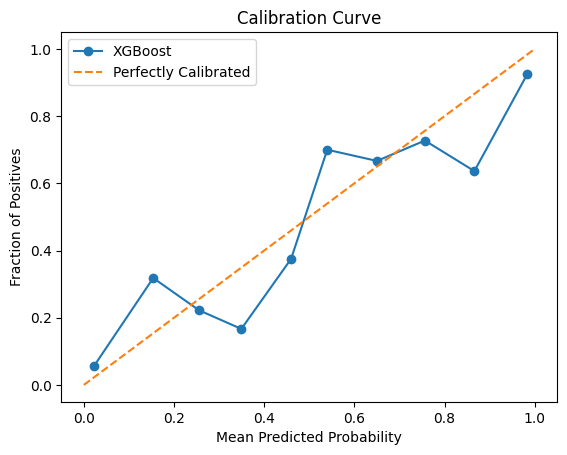

In [ ]:
# calibration curve
y_probs = XGB_model.predict_proba(x_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


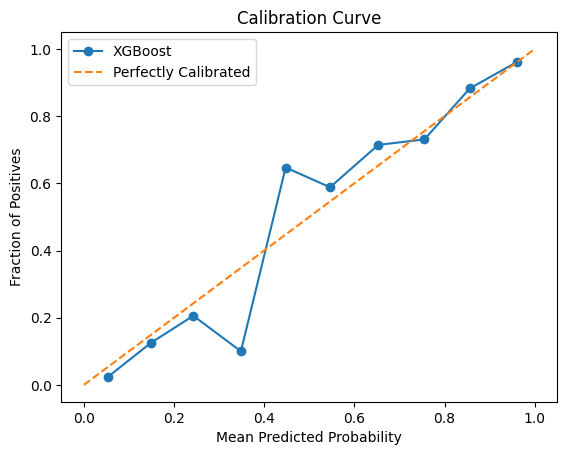

In [ ]:
# calibration curve
y_probs = RandomForest_model.predict_proba(x_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [ ]:
y_pred_rf = RandomForest_prediction
y_pred_xgb = XGB_model.predict(x_test)

contingency_table = np.array([
    [(y_test == y_pred_rf).sum(), (y_test != y_pred_rf).sum()],
    [(y_test == y_pred_xgb).sum(), (y_test != y_pred_xgb).sum()]
])


result = mcnemar(contingency_table, exact=True)
print(f"McNemar’s Test P-value: {result.pvalue}")

if result.pvalue < 0.05:
    print("The difference between models is statistically significant.")
else:
    print("No significant difference between models.")



McNemar’s Test P-value: 9.54157122394913e-49
The difference between models is statistically significant.


the p-value is exteremely small which means that two model doesn't make same errors. and one of them is likwly better

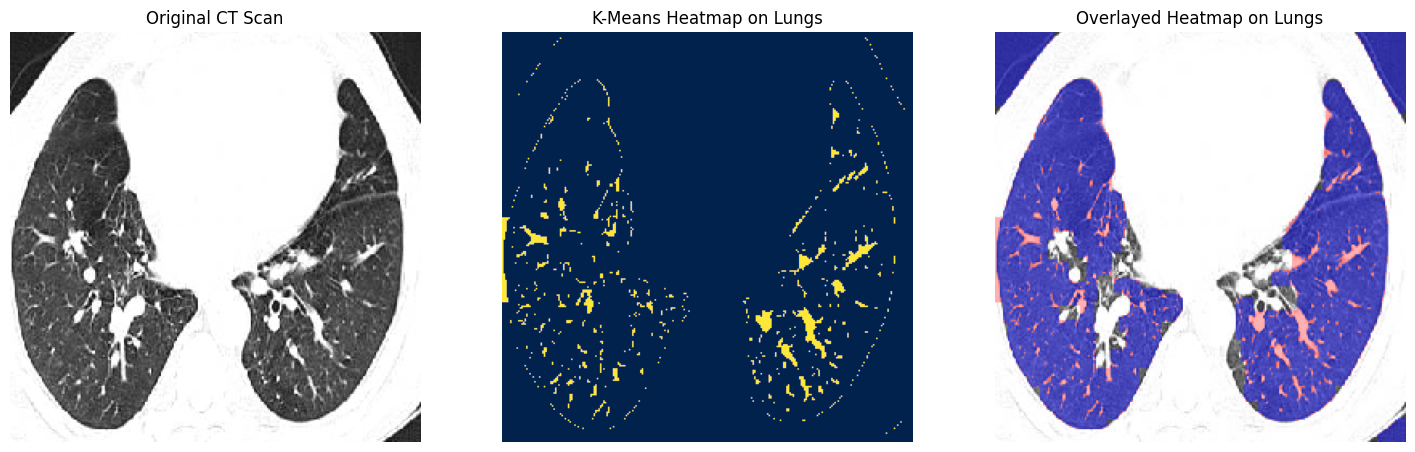

In [ ]:
def loadimage(img_path, target_size=(256, 256)):
    img = IMG.load_img(img_path, target_size=target_size, color_mode="grayscale")
    img_array = IMG.img_to_array(img).astype('uint8').squeeze()  # Remove single color channel
    return img_array

img_array = loadimage("Images/COVID/Covid (1240).png")
_, mask = cv2.threshold(img_array, 200, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
region = cv2.bitwise_and(img_array, img_array, mask=mask)
pixel_values = region[mask > 0].reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(pixel_values)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
high_density_cluster = np.argmax(cluster_centers)
segmented_lungs = np.zeros_like(region)
segmented_lungs[mask > 0] = labels.reshape(-1)
heatmap = (segmented_lungs == high_density_cluster).astype(np.uint8) * 255
heatmap = cv2.bitwise_and(heatmap, heatmap, mask=mask)
heatmap_normalized = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
original_ct_colored = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
overlay = original_ct_colored.copy()
overlay[mask > 0] = cv2.addWeighted(original_ct_colored[mask > 0], 0.7, heatmap_colored[mask > 0], 0.9, 0)


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img_array, cmap="gray") 
ax[0].set_title("Original CT Scan")
ax[0].axis("off")

ax[1].imshow(heatmap_normalized, cmap="cividis")
ax[1].set_title("K-Means Heatmap on Lungs")
ax[1].axis("off")

ax[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
ax[2].set_title("Overlayed Heatmap on Lungs")
ax[2].axis("off")

plt.show()

# Data PipeLine

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb

# Step 1: Load Data
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for file in os.listdir(path):
                img_path = os.path.join(path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Step 2: Feature Extraction
def extract_features(images):
    features = []
    for img in images:
        hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_features)
    return np.array(features)

# Step 3: Preprocessing
def preprocess_data(X, y):
    X = X.reshape(X.shape[0], -1)  # Flatten images
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

# Step 4: Train-Test Split
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Train Models
def train_models(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

# Step 6: Evaluate Models
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
    return results

# Step 7: Hyperparameter Tuning (Example for Random Forest)
def tune_model(X_train, y_train):
    param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Pipeline Execution
if __name__ == "__main__":
    folder = "path_to_your_dataset"  # Change this to your dataset path
    images, labels = load_images_from_folder(folder)
    X = extract_features(images)
    X_scaled, y = preprocess_data(X, labels)
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)
    models = train_models(X_train, y_train)
    results = evaluate_models(models, X_test, y_test)
    best_model = tune_model(X_train, y_train)
    print("Best Tuned Model:", best_model)